In [1]:
import sys
# import comet_ml
import torch

import numpy as np

from sklearn.metrics import (
    f1_score, confusion_matrix, classification_report,
    balanced_accuracy_score, accuracy_score,
)
# from transformers.integrations import CometCallback

sys.path.append('..')
from lib.utils import set_seed, get_device
from lib.utils.constants import RANDOM_SEED
from lib.data.loading import pd_read_jsonl_file

In [2]:
# import os
# from dotenv import load_dotenv

# load_dotenv()

# comet_api_key = os.getenv("COMET_API_KEY")
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [16]:
import torch

torch.cuda.empty_cache()

In [3]:
set_seed(RANDOM_SEED)

DEVICE = get_device()
print(f'Using device: {DEVICE}')

Using device: cuda


In [4]:
df_en_train = pd_read_jsonl_file('../data/en_train.jsonl')
df_en_dev = pd_read_jsonl_file('../data/en_dev.jsonl')
df_en_test = pd_read_jsonl_file('../data/en_devtest_text_id_only.jsonl')

In [5]:
df_en_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610767 entries, 0 to 610766
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          610767 non-null  object
 1   source      610767 non-null  object
 2   sub_source  610767 non-null  object
 3   lang        610767 non-null  object
 4   model       610767 non-null  object
 5   label       610767 non-null  int64 
 6   text        610767 non-null  object
dtypes: int64(1), object(6)
memory usage: 32.6+ MB


In [6]:
df_en_train.head()

,id,source,sub_source,lang,model,label,text
0,f05034ca-d1da-445d-a6a2-5869ade0dfc3,m4gt,reddit,en,llama3-8b,1,Hitler's plans for the succession and power st...
1,e7d7fe23-3709-4e14-aa2d-d76821dcbdf6,mage,squad,en,human,0,The Bush administration then turned its attent...
2,1a68d42e-4202-4e36-bceb-02d693440a14,mage,yelp,en,human,0,Really really the best pedi ever! Pho was so a...
3,5de844ab-c197-4378-b144-c3a46e3f5b67,mage,xsum,en,human,0,The PS42m MV Loch Seaforth made its first pass...
4,cdf050ad-7d90-4235-b7c6-46ca6cfc4382,m4gt,wikipedia,en,human,0,Malta participated in the Eurovision Song Cont...


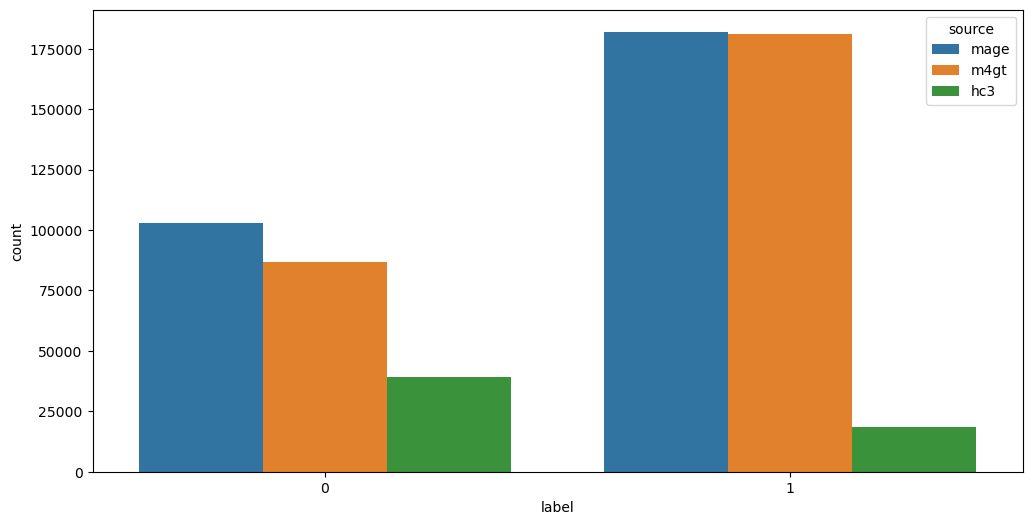

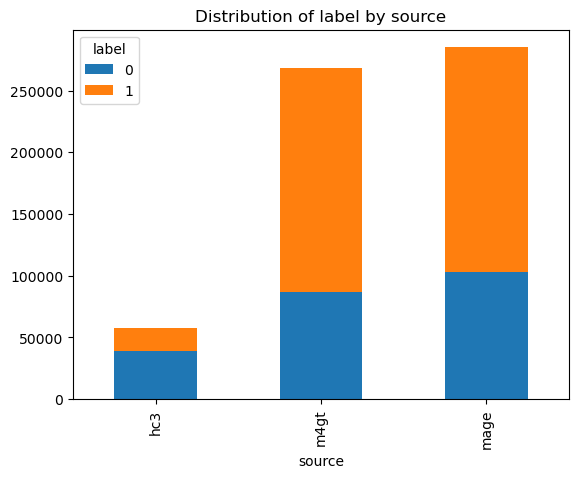

In [7]:
# Plot distribution of the lable column by the source column and plot count of each label by source
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(data=df_en_train, x='label', hue='source')
# count each label by source
df_en_train.groupby(['source', 'label']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribution of label by source')
plt.show()

# Split the datasets by the source

In [5]:
ood_datasets = {}

train_sources = df_en_train['source'].unique().tolist()
for source in train_sources:
    # Get samples with the same source
    ood_train = df_en_train[df_en_train['source'] == source]
    # Randomly keep same number of samples by label
    ood_train = ood_train.groupby('label').apply(lambda x: x.sample(ood_train['label'].value_counts().min(), random_state=RANDOM_SEED))
    # Shuffle samples
    ood_train = ood_train.sample(frac=1, random_state=RANDOM_SEED)

    # For validation keep all samples with different source
    ood_dev = df_en_train[df_en_train['source'] != source]
    # Randomly keep same number of samples by label
    ood_dev = ood_dev.groupby('label').apply(lambda x: x.sample(ood_dev['label'].value_counts().min(), random_state=RANDOM_SEED))
    ood_dev = ood_dev.sample(frac=1, random_state=RANDOM_SEED)

    ood_datasets[source] = {
        'train': ood_train,
        'dev': ood_dev,
    }

# Fine-tune models

In [6]:
MODEL_NAME = "distilbert/distilbert-base-cased"

MAX_LEN = 512

TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 16
LEARNING_RATE = 2e-4
NUM_EPOCHS = 2
WEIGHT_DECAY = 1e-2

training_params = {
    "model_name": MODEL_NAME,
    "max_len": MAX_LEN,
    "train_batch_size": TRAIN_BATCH_SIZE,
    "eval_batch_size": EVAL_BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "num_epochs": NUM_EPOCHS,
    "weight_decay": WEIGHT_DECAY,
    "seed": RANDOM_SEED,
}

In [7]:
import torch
import torch.nn.functional as F

from transformers import Trainer


class WeightedCrossEntropyTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            self.class_weights = torch.tensor(
                class_weights, dtype=torch.float32
        ).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [15]:
from datasets import Dataset, DatasetDict
from transformers import DataCollatorWithPadding, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        'macro_f1': f1_score(predictions, labels, average='macro'),
        'accuracy': accuracy_score(predictions,labels),
        'balanced_accuracy': balanced_accuracy_score(predictions, labels),
    }


def preprocess_dataset(tokenizer, ds, max_len=MAX_LEN):
    return tokenizer(ds['text'], truncation=True, max_length=max_len)


def set_model_parameters(model):
    for param in model.parameters():
        param.requires_grad = False

    for param in model.distilbert.transformer.layer[-1].parameters():
        param.requires_grad = True

    for param in model.classifier.parameters():
        param.requires_grad = True

    return model


def fine_tune_models(datasets, MODEL_NAME, training_params, device=DEVICE):
    fine_tuned_models = {}

    for source, ds in datasets.items():
        print(
            f"Fine-tuning model {training_params['num_epochs']} epochs on source: {source}"
        )

        model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
        model = set_model_parameters(model)
        model.to(device)

        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

        # class_weights = (
        #     1 / ds['train'].label.value_counts(normalize=True).sort_index()
        # ).tolist()
        # class_weights = torch.tensor(class_weights)
        # class_weights = class_weights / class_weights.sum()

        ds_train = Dataset.from_pandas(ds['train']).shuffle(
            seed=training_params['seed'],
        )
        ds_dev = Dataset.from_pandas(ds['dev'])

        dataset = DatasetDict({
            'train': ds_train, #preprocess_dataset(tokenizer, ds_train, training_params['max_len']).set_format("torch"),
            'dev': ds_dev, # preprocess_dataset(tokenizer, ds_dev, training_params['max_len']).set_format("torch"),
        })

        tokenized_dataset = dataset.map(
            lambda d: preprocess_dataset(tokenizer, d, training_params['max_len']),
            batched=True,
        )
        tokenized_dataset.set_format("torch")

        collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

        training_args = TrainingArguments(
            output_dir=f'../results/subtask_a/{MODEL_NAME}/{source}',
            learning_rate=training_params["learning_rate"],
            per_device_train_batch_size=training_params["train_batch_size"],
            per_device_eval_batch_size=training_params["eval_batch_size"],
            num_train_epochs=training_params["num_epochs"],
            weight_decay=training_params["weight_decay"],
            evaluation_strategy='epoch',
            save_strategy='epoch',
            load_best_model_at_end=True,
            seed=training_params["seed"],
        )

        trainer = WeightedCrossEntropyTrainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_dataset['train'],
            eval_dataset=tokenized_dataset['dev'],
            tokenizer=tokenizer,
            data_collator=collate_fn,
            compute_metrics=compute_metrics,
            # class_weights=class_weights,
            # callbacks=[CometCallback()],
        )

        train_result = trainer.train()

        metrics = train_result.metrics
        max_train_samples = len(ds_train)
        metrics["train_samples"] = min(max_train_samples, len(ds_train))
        trainer.log_metrics("train", metrics)
        trainer.save_metrics("train", metrics)
        trainer.save_state()

        trainer.save_model(f"../results/subtask_a/{MODEL_NAME}/{source}/fine-tuned-model")

        fine_tuned_models[source] = f"../results/subtask_a/{MODEL_NAME}/{source}/fine-tuned-model"

    return fine_tuned_models

In [17]:
models = fine_tune_models(
    ood_datasets,
    MODEL_NAME,
    training_params,
    DEVICE,
)

Fine-tuning model 2 epochs on source: m4gt


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/173564 [00:00<?, ? examples/s]

Map:   0%|          | 0/284280 [00:00<?, ? examples/s]

/root/.conda/envs/pytorch/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
comet_ml version 3.39.0 is installed, but version 3.43.2 or higher is required. Please update comet_ml to the latest version to enable Comet logging with pip install 'comet-ml>=3.43.2'.


[2024-10-06 17:49:38,250] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: teodormarchitan (unibuc-nlp). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Balanced Accuracy
1,0.093800,1.154505,0.647483,0.657802,0.678730
2,0.064600,1.611016,0.622195,0.644621,0.689651


***** train metrics *****
  epoch                    =        2.0
  total_flos               = 42825139GF
  train_loss               =     0.0976
  train_runtime            = 0:32:30.99
  train_samples            =     173564
  train_samples_per_second =    177.924
  train_steps_per_second   =       2.78
Fine-tuning model 2 epochs on source: mage


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/root/.conda/envs/pytorch/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/root/.conda/envs/pytorch/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.

Map:   0%|          | 0/206000 [00:00<?, ? examples/s]

Map:   0%|          | 0/251844 [00:00<?, ? examples/s]

/root/.conda/envs/pytorch/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
comet_ml version 3.39.0 is installed, but version 3.43.2 or higher is required. Please update comet_ml to the latest version to enable Comet logging with pip install 'comet-ml>=3.43.2'.


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Balanced Accuracy
1,0.214100,0.740007,0.756549,0.763211,0.795561
2,0.150700,0.931273,0.735500,0.744882,0.785368


***** train metrics *****
  epoch                    =        2.0
  total_flos               = 50823532GF
  train_loss               =     0.2178
  train_runtime            = 0:32:56.29
  train_samples            =     206000
  train_samples_per_second =    208.471
  train_steps_per_second   =      3.258
Fine-tuning model 2 epochs on source: hc3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/root/.conda/envs/pytorch/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/root/.conda/envs/pytorch/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.

Map:   0%|          | 0/37342 [00:00<?, ? examples/s]

Map:   0%|          | 0/379564 [00:00<?, ? examples/s]

***** train metrics *****
  epoch                    =        2.0
  total_flos               =  7878216GF
  train_loss               =     0.0321
  train_runtime            = 0:27:33.81
  train_samples            =      37342
  train_samples_per_second =     45.159
  train_steps_per_second   =      0.706


In [18]:
import pandas as pd
from tqdm import tqdm


def make_predictions(model, tokenizer, df, device, file_path, max_len=MAX_LEN, batch_size=16):
    model.eval()

    all_ids = []
    all_predictions = []
    with torch.no_grad():
        for i in tqdm(range(0, len(df), batch_size)):
            ids = df[i:i + batch_size].id.tolist()
            texts = df[i:i + batch_size].text.tolist()

            inputs = tokenizer(texts, truncation=True, padding=True, max_length=max_len, return_tensors="pt")

            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask).logits
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_ids.extend(ids)
            all_predictions.extend(preds)

    df_predictions = pd.DataFrame({
        "id": all_ids,
        "label": all_predictions,
    })

    if file_path is not None:
        df_predictions.to_json(
            file_path,
            orient="records",
            lines=True,
        )

    return df_predictions

In [ ]:
results = {}

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
for model_source, model_path in models.items():
    print(f"Make predictions using model trained on {model_source}...")

    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(DEVICE)
    
    predictions = make_predictions(
        model,
        tokenizer,
        df_en_dev,
        DEVICE,
        None,
    )
    
    results[model_source] = predictions

Make predictions using model trained on m4gt...


100%|██████████| 16360/16360 [12:41<00:00, 21.49it/s]


Make predictions using model trained on mage...


100%|██████████| 16360/16360 [12:42<00:00, 21.47it/s]


Make predictions using model trained on hc3...


 87%|████████▋ | 14214/16360 [11:05<01:39, 21.53it/s]

In [28]:
results

{'m4gt':                                           id  label
 0       e0c8d183-c377-4af0-a12c-2204d75cd5f0      1
 1       2b6d18d5-993f-486f-a631-986f46ec7ba0      0
 2       327667aa-fbe2-46dc-b2e9-31c7618845ca      1
 3       2fa81a5f-a6da-4cd5-ab0b-22ea4e0464b9      1
 4       61b935f0-3a00-4441-a185-34216bc5b55a      1
 ...                                      ...    ...
 261753  af2bdf80-599d-4914-a5a0-b4bf77ef5955      0
 261754  2750df23-0e0a-4249-bc33-4469c36c5be0      0
 261755  c75b0dbe-c307-4d33-90e6-ab5ad1b49c57      1
 261756  c4ecc218-3860-4a22-a7d2-f21c2577e6b1      0
 261757  3d96c939-b3a3-4d60-a11c-64d2203ac905      0
 
 [261758 rows x 2 columns],
 'mage':                                           id  label
 0       e0c8d183-c377-4af0-a12c-2204d75cd5f0      1
 1       2b6d18d5-993f-486f-a631-986f46ec7ba0      1
 2       327667aa-fbe2-46dc-b2e9-31c7618845ca      1
 3       2fa81a5f-a6da-4cd5-ab0b-22ea4e0464b9      1
 4       61b935f0-3a00-4441-a185-34216bc5b55a      1


In [31]:
result_metrics = {}
labels = df_en_dev.label.tolist()
for source, predictions in results.items():
    result_metrics[source] = {
        'macro_f1': f1_score(predictions.label.tolist(), labels, average='macro'),
        'accuracy': accuracy_score(predictions.label.tolist(),labels),
        'balanced_accuracy': balanced_accuracy_score(predictions.label.tolist(), labels),
    }

In [34]:
print(result_metrics)

{'m4gt': {'macro_f1': 0.7902867230152759, 'accuracy': 0.8112569625379167, 'balanced_accuracy': 0.8090442994372781}, 'mage': {'macro_f1': 0.8346148158964593, 'accuracy': 0.8516224910031404, 'balanced_accuracy': 0.8579871208050153}, 'hc3': {'macro_f1': 0.641546419287454, 'accuracy': 0.6417721712421397, 'balanced_accuracy': 0.6964978229700012}}


In [40]:
combined_predictions = []
for idx, row in df_en_dev.iterrows():
    sample_id = row['id']
    sample_label = row['label']
    
    human_votes = 0
    machine_votes = 0
    for source, predictions in results.items():
        if predictions.iloc[idx]['label'] == 0:
            human_votes += 1
        else:
            machine_votes += 1
        
    prediction = 0 if human_votes > machine_votes else 1
    combined_predictions.append(prediction)

In [44]:
result_metrics['combined'] = {
    'macro_f1': f1_score(combined_predictions, labels, average='macro'),
    'accuracy': accuracy_score(combined_predictions,labels),
    'balanced_accuracy': balanced_accuracy_score(combined_predictions, labels),
}

In [45]:
print(result_metrics)

{'m4gt': {'macro_f1': 0.7902867230152759, 'accuracy': 0.8112569625379167, 'balanced_accuracy': 0.8090442994372781}, 'mage': {'macro_f1': 0.8346148158964593, 'accuracy': 0.8516224910031404, 'balanced_accuracy': 0.8579871208050153}, 'hc3': {'macro_f1': 0.641546419287454, 'accuracy': 0.6417721712421397, 'balanced_accuracy': 0.6964978229700012}, 'combined': {'macro_f1': 0.8393537848848429, 'accuracy': 0.8477716058343967, 'balanced_accuracy': 0.8364809511778708}}


# Make combined predictions on the test dataset

In [49]:
test_results = {}

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
for model_source, model_path in models.items():
    print(f"Make predictions using model trained on {model_source}...")

    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(DEVICE)
    
    predictions = make_predictions(
        model,
        tokenizer,
        df_en_dev,
        DEVICE,
        None,
    )
    
    test_results[model_source] = predictions

/root/.conda/envs/pytorch/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Make predictions using model trained on m4gt...


100%|██████████| 16360/16360 [12:42<00:00, 21.46it/s]


Make predictions using model trained on mage...


100%|██████████| 16360/16360 [12:42<00:00, 21.47it/s]


Make predictions using model trained on hc3...


100%|██████████| 16360/16360 [12:43<00:00, 21.43it/s]


In [ ]:
import json


with open(f"../results/subtask_a/{MODEL_NAME}/test_predictions.json", "w") as f:
    json.dump(test_results, f)

In [52]:
test_ids = []
combined_test_predictions = []
for idx, row in df_en_test.iterrows():
    sample_id = row['id']
    
    human_votes = 0
    machine_votes = 0
    for source, predictions in test_results.items():
        if predictions.iloc[idx]['label'] == 0:
            human_votes += 1
        else:
            machine_votes += 1
        
    prediction = 0 if human_votes > machine_votes else 1
    
    test_ids.append(sample_id)
    combined_test_predictions.append(prediction)

In [53]:
df_combined_test_predictions = pd.DataFrame({
    "id": test_ids,
    "label": combined_test_predictions,
})

In [56]:
df_combined_test_predictions['label'].value_counts(normalize=True)

label
1    0.602236
0    0.397764
Name: proportion, dtype: float64

In [57]:
df_combined_test_predictions.to_json(
    f"../results/subtask_a/{MODEL_NAME}/test_combined_predictions.jsonl",
    orient="records",
    lines=True,
)